<a href="https://colab.research.google.com/github/wangdedi1997/spib/blob/main/examples/tutorial1_model_potential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPIB Tutorial 1: Model potential system
This notebook aims to serve as a simple introduction to the state predictive information bottleneck method of [Wang and Tiwary 2021](https://aip.scitation.org/doi/abs/10.1063/5.0038198). The code is implemented using Pytorch.

<img src="https://github.com/tiwarylab/State-Predictive-Information-Bottleneck/blob/main/fig/Fig_FW_example.png?raw=1">

## Install SPIB using pypi

In [ ]:
pip install spib

Looking in indexes: https://test.pypi.org/simple/


## Download the trajectory data generated from a four well model potential system

In [ ]:
!gdown 1cWtyhTo7OsJRSYv38a9gYISpqwW186lB

Downloading...
From: https://drive.google.com/uc?id=1cWtyhTo7OsJRSYv38a9gYISpqwW186lB
To: /content/Four_Well_beta3_gamma4_traj_data.npy
100% 19.2M/19.2M [00:00<00:00, 92.1MB/s]


In [ ]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

plt.rcParams['figure.figsize'] = [25, 20]
np.random.seed(42)

In [ ]:
large = 54; med = 36; small = 24
l_width = 3; m_width = 1.5; s_width = 0.7
params = {'axes.titlesize': large,
          'legend.fontsize': large,
          'legend.title_fontsize':large,
          'figure.figsize': (16, 10),
          'axes.labelsize': large,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'lines.linewidth': l_width,
          'lines.markersize': 10,
          'axes.linewidth': l_width,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'xtick.minor.size': 4,
          'ytick.minor.size': 4,
          'xtick.major.width': m_width,
          'ytick.major.width': m_width,
          'xtick.minor.width': s_width,
          'ytick.minor.width': s_width,
          'grid.linewidth': m_width}
plt.rcParams.update(params)

## Data Preparation
The trajectory data can be generated from the molecular dynamics simulation or experiements. Here, we use a sample trajectory generated from Langevin dynamics simulation of a four-well analytical potential.

In [ ]:
# Load trajectory data
traj_data = np.load("Four_Well_beta3_gamma4_traj_data.npy")

### Visualization of the trajectory

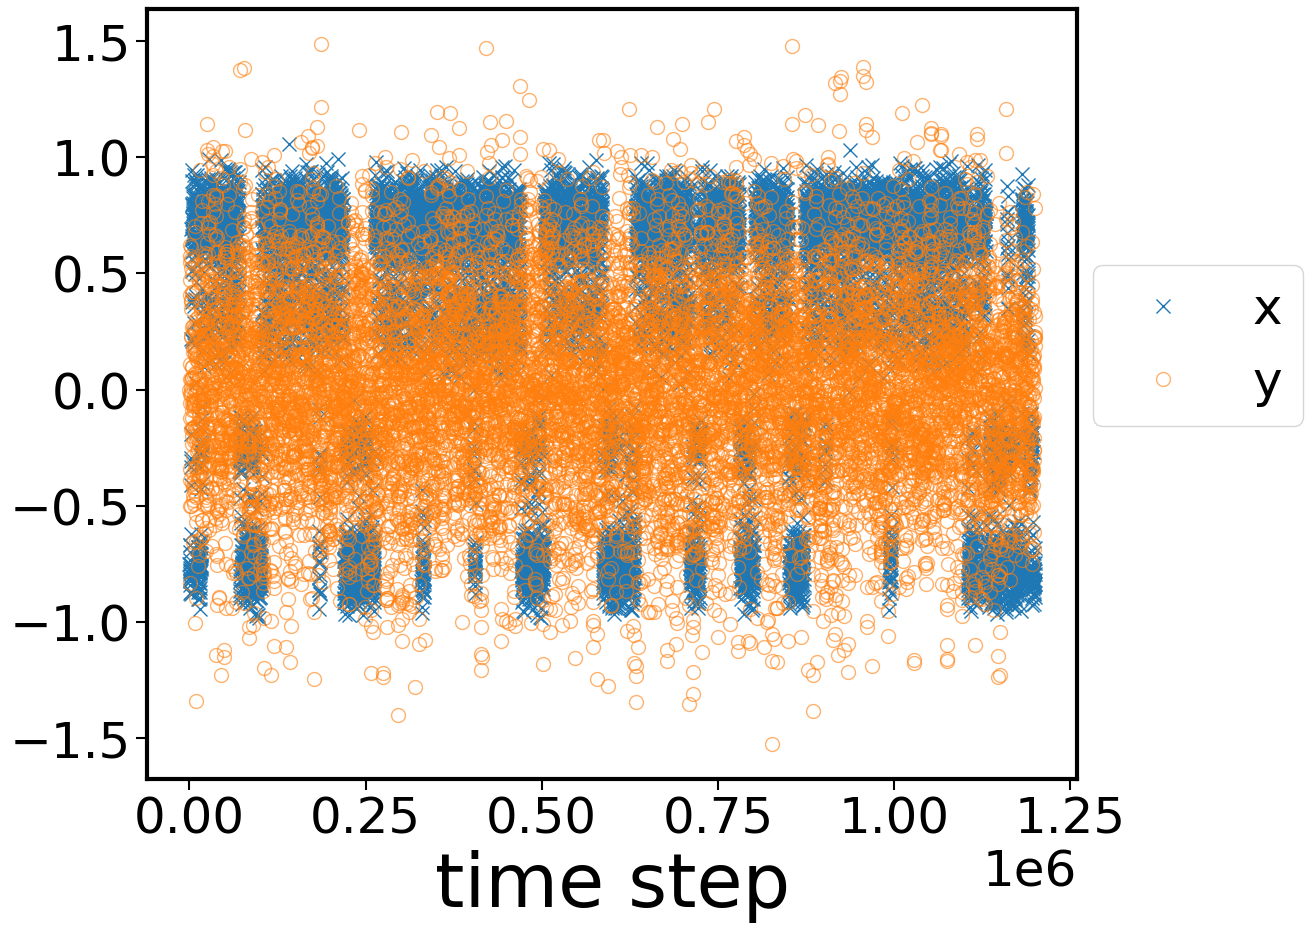

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

traj_len = traj_data.shape[0]
t = np.arange(traj_data.shape[0])
ax.plot(t[::100],traj_data[::100,0],'x',label='x')
ax.plot(t[::100],traj_data[::100,1],'o',fillstyle='none',label='y', alpha=0.6)
ax.set_xlabel('time step')
ax.legend(fontsize=36,bbox_to_anchor=(0.99, 0.7))

In [ ]:
# The four-well analytical potential along x
def potential_fn_FW(x):
    A=0.6
    a=80
    B=0.2
    b=80
    C=0.5
    c=40
    return 2*(x**8+A*np.exp(-a*x**2)+B*np.exp(-b*(x-0.5)**2)+C*np.exp(-c*(x+0.5)**2))+(x**2-1)**2

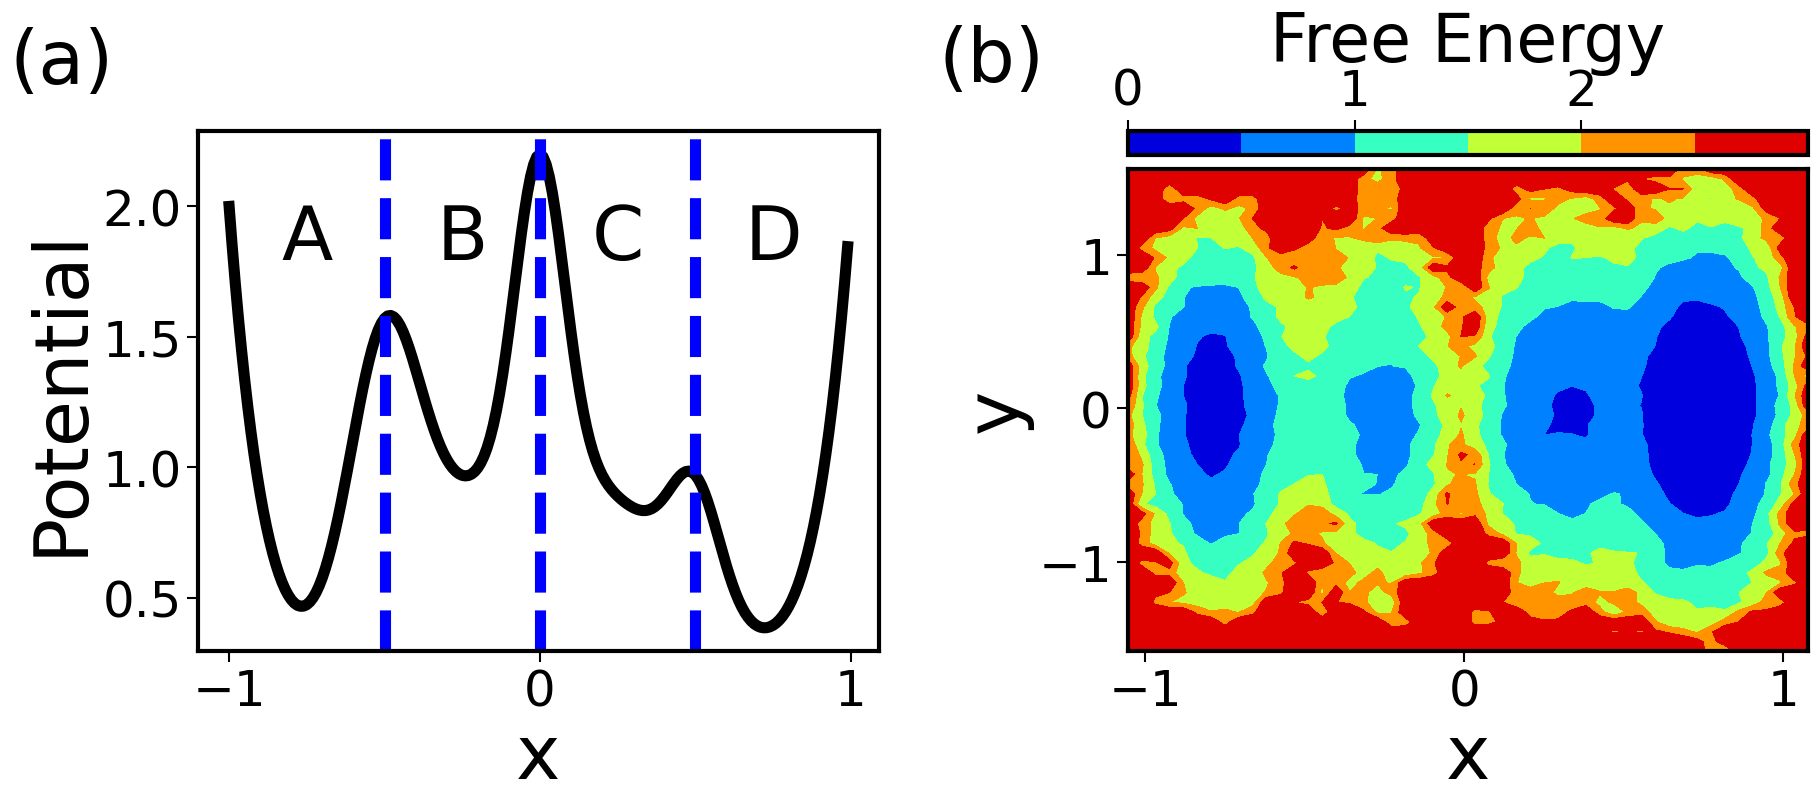

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1,2,figsize=(18,8))

beta=3
lw=8

x=np.arange(-1,1,0.01)
v=potential_fn_FW(x)
ax[0].plot(x,v,color='k',lw=lw)
ax[0].axvline(x=0,color='b',linestyle='--',lw=lw)
ax[0].axvline(x=-0.5,color='b',linestyle='--',lw=lw)
ax[0].axvline(x=0.5,color='b',linestyle='--',lw=lw)
ax[0].text(-0.75, 1.8, 'A', horizontalalignment='center',fontsize=54)
ax[0].text(-0.25, 1.8, 'B', horizontalalignment='center', fontsize=54)
ax[0].text(0.25, 1.8, 'C', horizontalalignment='center',fontsize=54)
ax[0].text(0.75, 1.8, 'D', horizontalalignment='center', fontsize=54)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Potential")

ax[0].text(-0.2, 1.2, '(a)', horizontalalignment='center',
             transform=ax[0].transAxes,fontsize=54, va='top')

FW_counts,FW_xbins,FW_ybins,images = plt.hist2d(traj_data[:,0],traj_data[:,1],bins=50)
FW_counts[FW_counts==0]=FW_counts[FW_counts!=0].min()
FW_G=-np.log(FW_counts)/beta
FW_G=FW_G-np.nanmin(FW_G)

h0=ax[1].contourf(FW_G.transpose(),levels=5,extent=[FW_xbins[0],FW_xbins[-1],FW_ybins[0],FW_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,FW_G.max(),1)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label('Free Energy',fontsize=48)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax[1].set_xlabel("x")
ax[1].set_ylabel('y')


ax[1].text(-0.2, 1.3, '(b)', horizontalalignment='center',
             transform=ax[1].transAxes,fontsize=54, va='top')

plt.tight_layout(pad=0.4, w_pad=5, h_pad=3.0)

### Generation of initial state labels

In [ ]:
# discretize the system along x to 10 states as initial state labels
index=0

x_max=traj_data[:,index].max()+0.01
x_min=traj_data[:,index].min()-0.01

state_num=10
eps=1e-3

x_det=(x_max-x_min+2*eps)/state_num

init_label=np.zeros((traj_data.shape[0])).astype(int)

x_list=np.array([(x_min-eps+n*x_det) for n in range(state_num+1)])

for j in range(state_num):
    indices=(traj_data[:,index]>x_list[j])&(traj_data[:,index]<=x_list[j+1])
    init_label[indices]=j

np.save('Four_Well_beta3_gamma4_init_label10.npy',init_label)

In [ ]:
# plot the initial state labels for four well potential system
import matplotlib
from matplotlib import colors as c
data=traj_data
labels=init_label

fig0, ax0 = plt.subplots(figsize=(9,6))
hist=ax0.hist2d(data[:,0],data[:,1],bins=100)

state_num=labels.max()+1
state_labels=np.arange(state_num)

x_max=np.max(data[:,0])
x_min=np.min(data[:,0])

eps=1e-3

x_det=(x_max-x_min+2*eps)/state_num

x_list=np.array([(x_min-eps+n*x_det) for n in range(state_num+1)])

hist_state=np.zeros([state_num]+list(hist[0].shape))

for i in range(state_num):
    hist_state[i]=ax0.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=(labels==i))[0]

init_label_map=np.argmax(hist_state,axis=0).astype(float)
init_label_map[hist[0]==0]=np.nan
plt.close(fig0)

Text(0, 0.5, 'y')

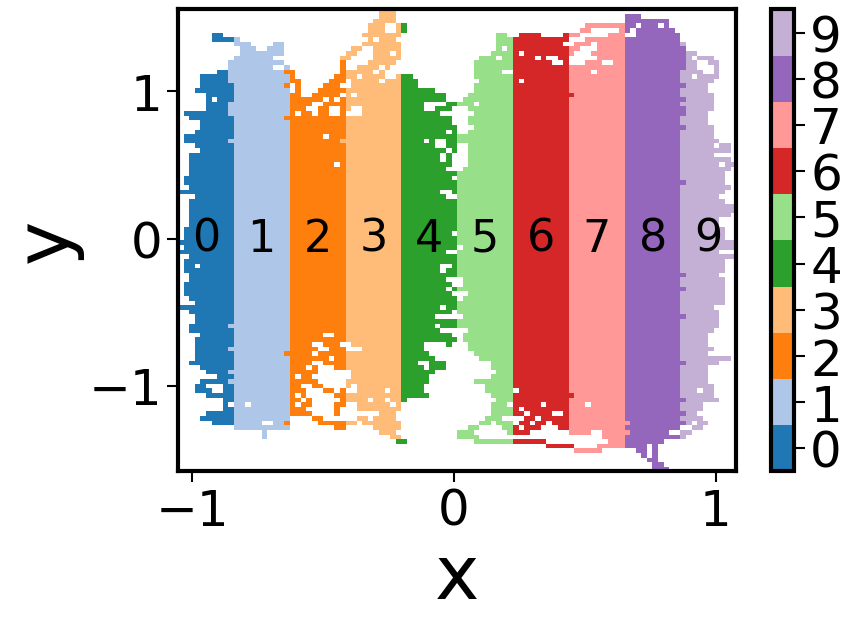

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))

fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: state_labels[x])
tickz = np.arange(0,len(state_labels))

cMap = c.ListedColormap(plt.cm.tab20.colors[0:10])
im=ax.pcolormesh(hist[1], hist[2], init_label_map.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
cb1 = fig.colorbar(im,ax=ax,format=fmt, ticks=tickz)

for i in range(state_num):
    ax.text((x_list[i]+x_list[i+1])/2,0,state_labels[i],horizontalalignment='center',verticalalignment='center',fontsize=32)

plt.xlabel("x")
plt.ylabel("y")

## Model

In [ ]:
# import the required packages
import numpy as np
import torch
import os
import torch.nn.functional as F
import random

from spib.spib import SPIB
from spib.utils import prepare_data, DataNormalize

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
default_device = torch.device("cpu")
print(device, default_device)

cpu cpu


In [ ]:
# Settings
# ------------------------------------------------------------------------------
# By default, we save all the results in subdirectories of the following path.
base_path = "SPIB"

# Model parameters
# Time delay delta t in terms of # of minimal time resolution of the trajectory data
dt = 50

# Dimension of bottleneck
z_dim = 1

# Encoder type ('Linear' or 'Nonlinear')
encoder_type = 'Nonlinear'

# Number of nodes in each hidden layer of the encoder
neuron_num1 = 16

# Number of nodes in each hidden layer of the encoder
neuron_num2 = 16


# Training parameters
batch_size = 2048

# tolerance of loss change for measuring the convergence of the training
tolerance = 0.005

# Number of epochs with the change of the state population smaller than the threshold after which this iteration of the training finishes
patience = 0

# Minimum refinements
refinements = 8

# Initial learning rate of Adam optimizer
learning_rate = 1e-3

# Hyper-parameter beta
beta = 1e-2


In [ ]:
# Random seed
seed = 0

# Set random seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
# data shape
data_shape = traj_data.shape[1:]
output_dim = np.max(init_label) + 1

# data normalization
data_transform = DataNormalize(mean=traj_data.mean(axis=0), std=traj_data.std(axis=0))

In [ ]:
len(traj_data)

1200000

We now can split data into train and test set

In [ ]:
# Evenly divide the ultra-long trajectory
num_div = 100
divtraj = []
divlabel = []
for i in range(num_div):
    if i != num_div - 1:
        divtraj.append(traj_data[int(i * len(traj_data) / num_div):int((i + 1) * len(traj_data) / num_div)])
        divlabel.append(
            init_label[int(i * len(init_label) / num_div):int((i + 1) * len(init_label) / num_div)])
    else:
        divtraj.append(traj_data[int(i * len(traj_data) / num_div):])
        divlabel.append(init_label[int(i * len(init_label) / num_div):])


In [ ]:
# split data into train and test set
indices = list(range(num_div))
split = int(np.floor(0.1 * num_div))

np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

In order to work with the SPIB it can be convenient to convert the list of trajectory data into a time-lagged dataset.

In [ ]:
# prepare the dataset for spib training
train_dataset, test_dataset = prepare_data(divtraj, divlabel, weight_list=None,
                                           output_dim=output_dim, lagtime=dt,
                                           train_indices=train_indices,
                                           test_indices=test_indices, device=device)

In [ ]:
# By default, we save all the results in subdirectories of the following path.
base_path = "SPIB"

IB_path = os.path.join(base_path, "spib")
IB_path

'SPIB/spib'

Now a SPIB instance can be created. For the full range of possible arguments, please see the API docs.

In [ ]:
IB = SPIB(output_dim=output_dim, data_shape=data_shape, encoder_type='Nonlinear', z_dim=z_dim,  lagtime=dt,
          beta=beta, learning_rate=learning_rate, device=device, path=IB_path, UpdateLabel=True,
          neuron_num1=neuron_num1, neuron_num2=neuron_num2, data_transform=data_transform)

Let’s train.

In [ ]:
IB.to(device)

IB.fit(train_dataset, test_dataset, batch_size=batch_size, tolerance=tolerance, patience=patience, refinements=refinements, index=seed)

Epoch 1:	Time 5.397544 s
Loss (train) 1.391829	KL loss (train): 1.064011
Reconstruction loss (train) 1.381189
Loss (test) 1.042559	KL loss (test): 1.894624
Reconstruction loss (test) 1.023613
State population:
[0.         0.22942445 0.         0.0449642  0.         0.
 0.133404   0.         0.5922074  0.        ]
Relative state population change=0.809616
training loss change=1.391829
Epoch 2:	Time 13.834552 s
Loss (train) 0.977909	KL loss (train): 2.026429
Reconstruction loss (train) 0.957645
Loss (test) 1.002674	KL loss (test): 2.083216
Reconstruction loss (test) 0.981842
State population:
[0.         0.22326359 0.         0.05122176 0.         0.
 0.1460846  0.         0.57943004 0.        ]
Relative state population change=0.086008
training loss change=-0.413920
Epoch 3:	Time 20.164076 s
Loss (train) 0.960255	KL loss (train): 2.125613
Reconstruction loss (train) 0.938999
Loss (test) 0.994889	KL loss (test): 2.113301
Reconstruction loss (test) 0.973756
State population:
[0.         0

SPIB(
  (data_transform): DataNormalize()
  (representative_weights): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=False)
    (1): Softmax(dim=0)
  )
  (encoder): Sequential(
    (0): DataNormalize()
    (1): Linear(in_features=2, out_features=16, bias=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
  )
  (encoder_mean): Linear(in_features=16, out_features=1, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
  )
  (decoder_output): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [ ]:
# save torch model
torch.save(IB, IB.output_path + '_final_SPIB%i.model' % seed)

We can visualize the progression of the training:

4


Text(0, 0.5, '# of states')

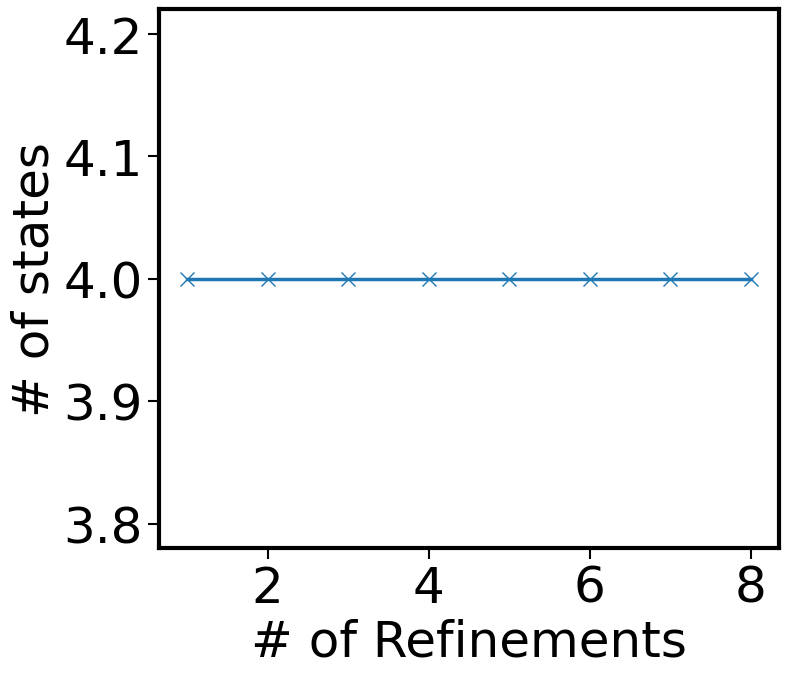

In [ ]:
# check the number of SPIB states vs # of Refinements
fig,ax = plt.subplots(figsize=(8,7))

data = np.array(IB.convergence_history)
ax.plot(data[:,0], data[:,2], linestyle='-', linewidth=2.5, marker='x')
print(IB.output_dim)

ax.set_xlabel(r'# of Refinements', fontsize=36)
ax.set_ylabel('# of states', fontsize=36)
#ax.legend(fontsize=24)

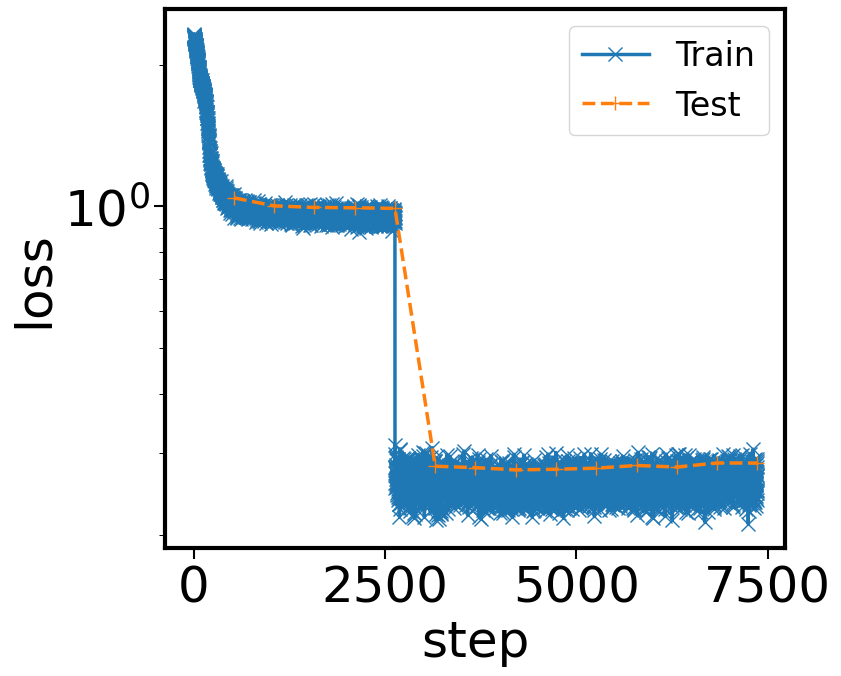

In [ ]:
# check loss vs # of Refinements
fig,ax = plt.subplots(figsize=(8,7))

data = np.array(IB.train_loss_history)
ax.plot(data[:,0], data[:,1], linestyle='-', linewidth=2.5, marker='x', label='Train')

data = np.array(IB.test_loss_history)
ax.plot(data[:,0], data[:,1], linestyle='--', linewidth=2.5, marker='+', label='Test')

ax.set_xlabel(r'step', fontsize=36)
ax.set_ylabel('loss', fontsize=36)
ax.set_yscale('log')
ax.legend(fontsize=24)

### Result Analysis

Transforming and plotting the learned representation and state labels for four well potential system:

In [ ]:
labels, prediction, z_latent, _ = IB.transform(traj_data, batch_size=batch_size, to_numpy=True)

Text(0, 0.5, 'y')

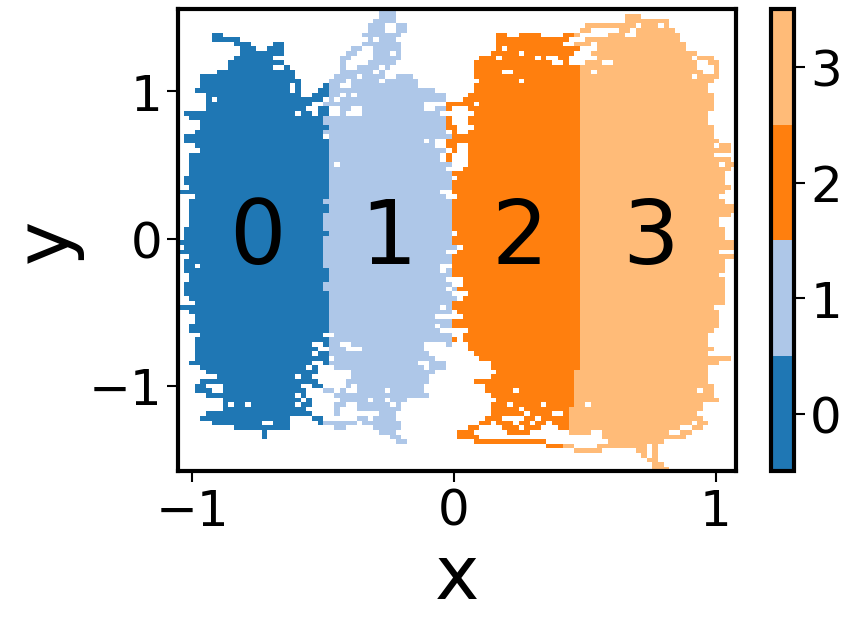

In [ ]:
# plot the learned state labels for four well potential system

import matplotlib
from matplotlib import colors as c
data=traj_data
hist=plt.hist2d(data[:,0],data[:,1],bins=100)

state_num=labels.max()+1
state_labels=np.arange(state_num)

hist_state=np.zeros([state_num]+list(hist[0].shape))

for i in range(state_num):
    hist_state[i]=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=(labels==i))[0]

label_map50=np.argmax(hist_state,axis=0).astype(float)
label_map50[hist[0]==0]=np.nan

plt.close()

fig, ax = plt.subplots(figsize=(9,6))

fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: state_labels[x])
tickz = np.arange(0,len(state_labels))

cMap = c.ListedColormap(plt.cm.tab20.colors[0:state_num])
im=ax.pcolormesh(hist[1], hist[2], label_map50.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
cb1 = fig.colorbar(im,ax=ax,format=fmt, ticks=tickz)

ax.text(-0.75,0,'0',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(0.75,0,'3',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(-0.25,0,'1',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(0.25,0,'2',horizontalalignment='center',verticalalignment='center',fontsize=64)

plt.xlabel("x")
plt.ylabel("y")

Note that the learned state labels for the four metastable states are reindexed from 0 to 3

<ipython-input-108-93cbb1b46d0d>:10: RuntimeWarning: invalid value encountered in divide
  RC=np.divide(hist_RC[0],hist[0])


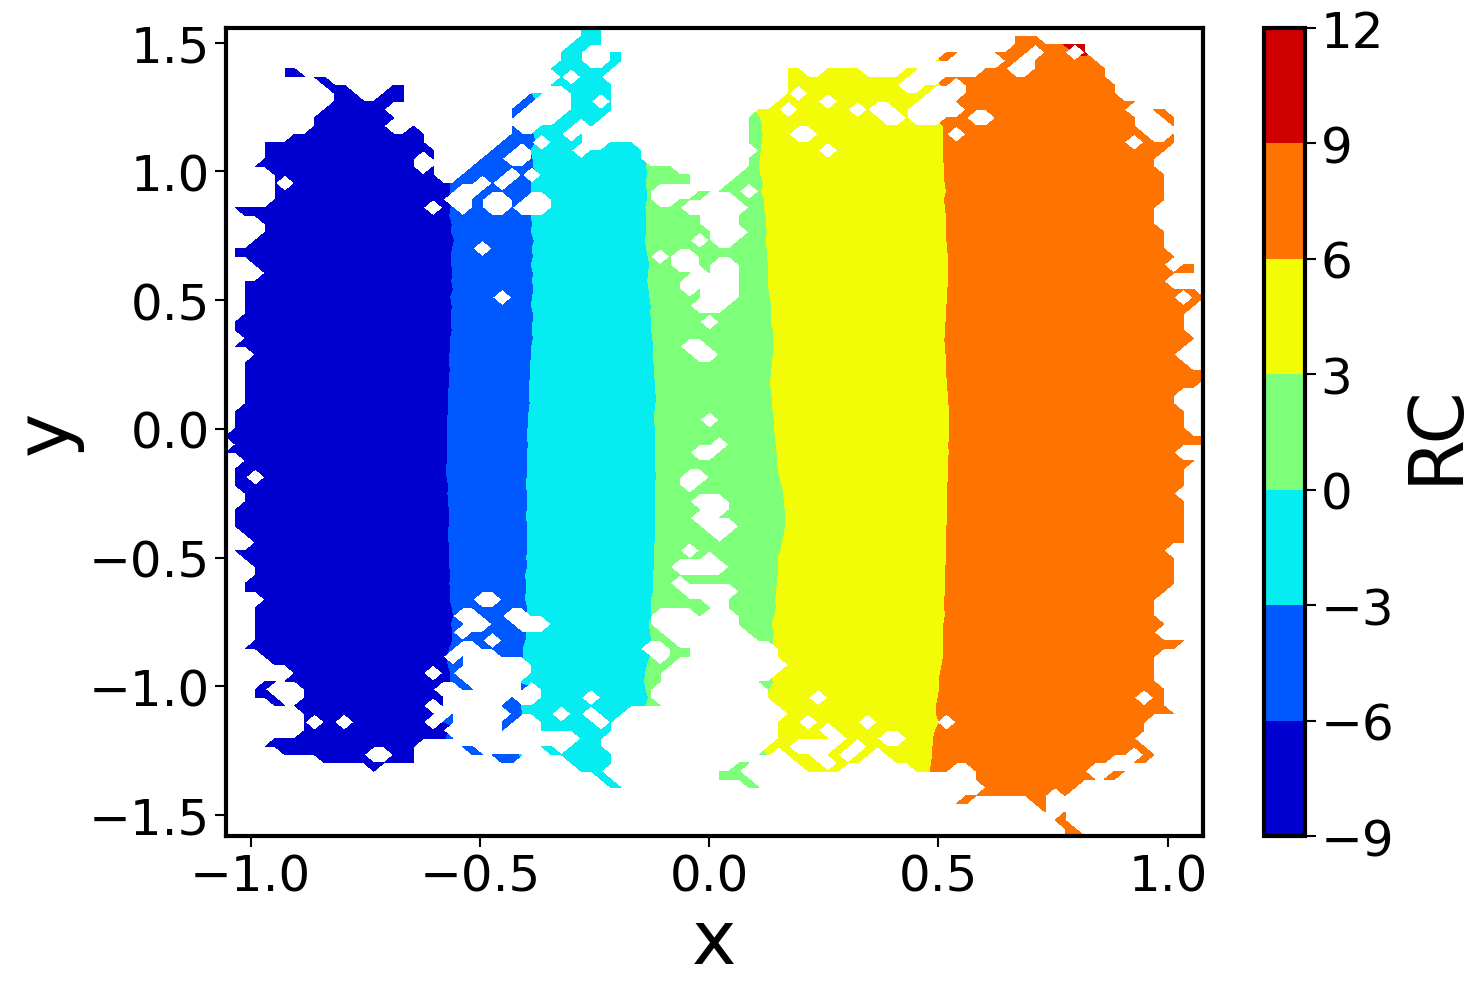

In [ ]:
# plot the learned RC for four well potential system
data=traj_data

hist=plt.hist2d(data[:,0],data[:,1],bins=100)
hist_RC=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=z_latent[:,0])
plt.close()

fig, ax = plt.subplots(figsize=(15,10))

RC=np.divide(hist_RC[0],hist[0])

im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=5,
                    cmap=plt.cm.jet)
cb1 = fig.colorbar(im,ax=ax)
cb1.set_label('RC')

plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()